## Problem Set 7
## MACS 40000
## Problem 1(a)

In [1]:
import numpy as np
import pandas as pd
import scipy.interpolate as si
import matplotlib.pyplot as plt
import warnings
import scipy.optimize as opt
warnings.filterwarnings("ignore")

In [2]:
def get_fert(totpers, graph=False):
    
    fert_data = (np.array([0.0, 0.0, 0.3, 12.3, 47.1, 80.7, 105.5, 98.0, 49.3, 10.4, 0.8, 0.0, 0.0]) / 2000)
    age_midp = np.array([9, 10, 12, 16, 18.5, 22, 27, 32, 37, 42, 47, 55, 56])
    fit_fert = si.interp1d(age_midp, fert_data, kind='cubic', bounds_error=False, fill_value=0)
    age_model = np.linspace(100 / totpers, 100, totpers) - (0.5 * 100 / totpers)
    fert_model = fit_fert(age_model)
    
    if graph:
        fig, ax = plt.subplots()
        plt.scatter(age_midp[2: -2], fert_data[2: -2], s=30, c='blue', marker ='o', label ='Data')
        plt.scatter([age_midp[0], age_midp[1], age_midp[-2], age_midp[-1]], [fert_data[0], fert_data[1], fert_data[-2], fert_data[-1]], s=30,
                      c='red', marker ='o', label ='Added data ')
        plt.scatter(age_model, fert_model, s=60, c='purple', marker ='*', label ='Model')
        plt.plot(np.linspace(0, 100, 1000), fit_fert(np.linspace(0, 100, 1000)), c='green', linestyle ='--',
                 label ='Cubic spline ')
        plt.title('Fertility rate by age', fontsize =15)
        plt.xlabel(r'Age')
        plt.ylabel(r'Fertility rate')
        plt.xlim((-0.1 , 100.1))
        plt.ylim((-0.005, 0.058))
        plt.legend()
        plt.show()
        
    return fert_model

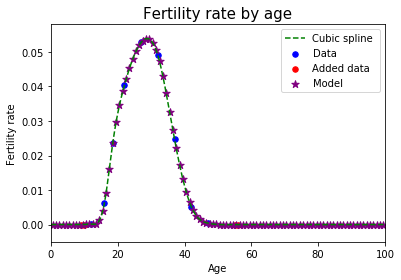

In [3]:
get_fert(100, True);

## Problem 1(b)

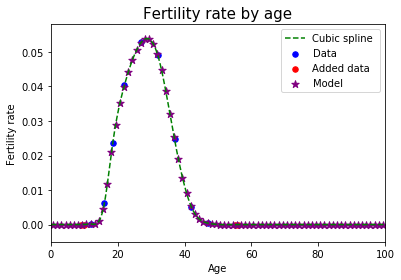

In [4]:
get_fert(80, True);

## Problem 1(c)

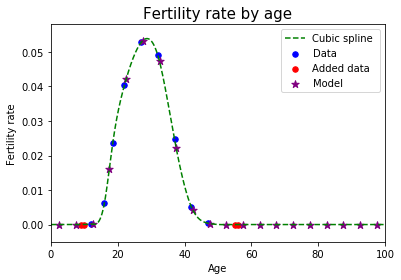

In [5]:
get_fert(20, True);

## Problem 2(a)

In [6]:
def get_mort(totpers, graph=False):
    mort_data = pd.read_table('mort_rates2011.csv', sep=',', thousands=',')
    mort_rate = np.array((((mort_data['Male Mort. Rate'] * mort_data['Num. Male Lives']) +\
                 (mort_data['Female Mort. Rate'] * mort_data['Num. Female Lives'])) /\
                 (mort_data['Num. Male Lives'] + mort_data['Num. Female Lives'])))[:-6]
    age_data = np.array(mort_data['Age'])[:-6]
    inf_mort = mort_rate[0]
    fit_mort = si.interp1d(age_data, mort_rate, kind='cubic', bounds_error=False, fill_value=0)
    age_model = np.linspace(100 / totpers, 100, totpers) - (0.5 * 100 / totpers) + 1
    mort_model= np.zeros(totpers)
    mort_model[0] = fit_mort(age_model[0])
    step = 100 / totpers
    for i in range (1, len(age_model) - 1):
        sub_per = fit_mort(np.linspace(step * i, step * (i + 1), step))
        mort_model[i] = 1- np.prod(1 - sub_per)
    mort_model[-1] = 1
                                    
    if graph:
        fig, ax = plt.subplots()
        plt.scatter(age_data, mort_rate, c='green', marker = 'o', s=10, label ='Data')
        plt.scatter(age_model, mort_model, c='red', marker = 'o', s=20, label ='Model')
        plt.title('Mortality rate by age', fontsize =15)
        plt.xlabel(r'Age')
        plt.ylabel(r'Mortality rate')
        plt.xlim((-0.1 , 101))
        plt.ylim((-0.1, 1.1))
        plt.legend()
        plt.show()
        
    return mort_model, inf_mort

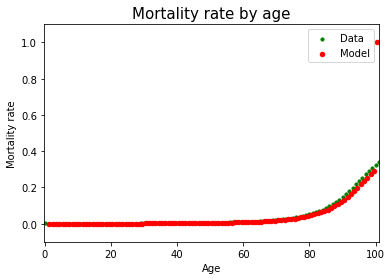

In [7]:
get_mort(100, True);

## Problem 2(b)

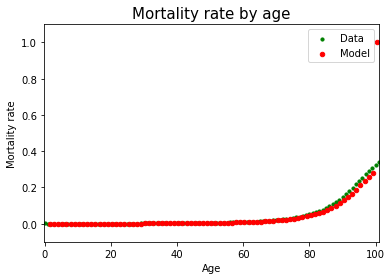

In [8]:
get_mort(80, True);

## Problem 2(c)

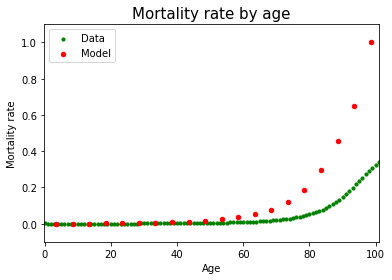

In [9]:
get_mort(20, True);

## Problem 3(a)

In [10]:
def get_imm_resid(totpers, graph = False):
    pop_data = pd.read_table('pop_data.csv', sep=',', thousands=',')
    pop_0 = np.array(pop_data['2012'][:-1])
    pop_1 = np.array(pop_data['2013'][:-1])
    
    mort_rate, inf_mort = get_mort(100)
    fert_rate = get_fert(100)
    imm_rate = np.zeros(100)
    imm_rate[0] = (pop_1[0] - (1 - inf_mort) * (pop_0 * fert_rate).sum()) / pop_0[0] 
    imm_rate[1:] = (pop_1[1:] - (1 - mort_rate[:-1]) * pop_0[:-1]) / pop_0[1:]
    fit_imm = si.interp1d(np.linspace(0, 100, 100), imm_rate, kind='cubic')
    age_model = np.linspace(100 / totpers, 100, totpers) - (0.5 * 100 / totpers)
    imm_model = fit_imm(age_model)
    if graph:
        fig, ax = plt.subplots()
        plt.plot(np.linspace(0, 100, 1000), fit_imm(np.linspace(0, 100, 1000)), c='green')
        plt.scatter(age_model, imm_model, c='red', marker = 'o', s=20)
        plt.title('Immigration rate by age', fontsize =15)
        plt.xlabel(r'Age')
        plt.ylabel(r'Immigration rate')
        plt.legend()
        plt.show()
        
    return imm_rate

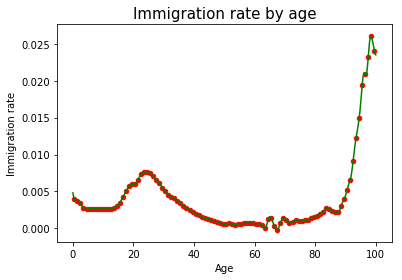

In [11]:
get_imm_resid(100, True);

## Problem 3(b)

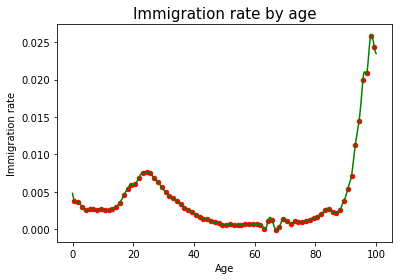

In [12]:
get_imm_resid(80, True);

## Problem 3(c)

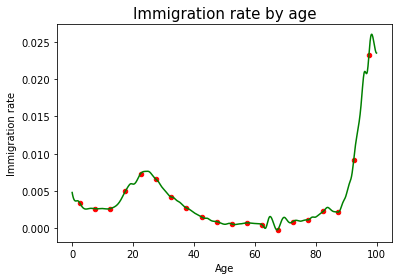

In [13]:
get_imm_resid(20, True);

## Problem 4(a)

In [14]:
def get_dist_stable(E, S, graph = False):
    fert_rate = get_fert(E + S)
    mort_rate, inf_mort = get_mort(E + S)

    imm_rates_orig = get_imm_resid(E + S)
    OMEGA_orig = np.zeros((E + S, E + S))
    OMEGA_orig[0, :] = ((1 - inf_mort) * fert_rate + np.hstack((imm_rates_orig[0], np.zeros(E + S - 1))))
    OMEGA_orig[1:, :-1] += np.diag(1 - mort_rate[:-1])
    OMEGA_orig[1:, 1:] += np.diag(imm_rates_orig[1:])

    eig_val, eig_vec = np.linalg.eig(OMEGA_orig)
    g_n_SS = (eig_val[np.isreal(eig_val)].real).max() - 1
    eig_vec_raw = eig_vec[:, (eig_val[np.isreal(eig_val)].real).argmax()].real
    omega_SS_orig = eig_vec_raw / eig_vec_raw.sum()
    
    if graph:
        fig, ax = plt.subplots()
        plt.plot(np.linspace(1, 100, 100), omega_SS_orig, c='green')
        plt.xlabel(r'Age')
        plt.ylabel(r'$\bar{\omega}_s$')
        plt.title('Steady-state stationary population distribution')
        plt.show()
        
    return fert_rate, mort_rate, inf_mort, imm_rates_orig, OMEGA_orig, omega_SS_orig, g_n_SS

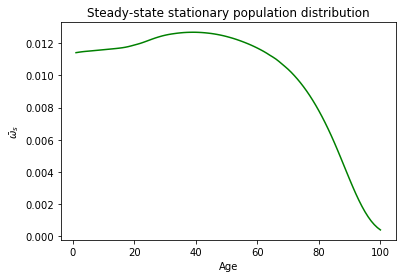

In [15]:
get_dist_stable(20, 80, True);

## Problem 4(b)

In [16]:
def get_omega_errors(imm_rate, *args):
    
    fert_rate, mort_rate, inf_mort, omega_now, g_n_SS = args
    omega_old = omega_now / omega_now.sum()
    
    t = len(fert_rate)
    omega = np.zeros((t, t))
    omega[0, :] = ((1 - inf_mort) * fert_rate + np.hstack((imm_rate[0], np.zeros(t - 1))))
    omega[1:, :-1] += np.diag(1 - mort_rate[:-1])
    omega[1:, 1:] += np.diag(imm_rate[1:])
    omega_new = np.dot(omega, omega_old) / (1 + g_n_SS)
    omega_errs = omega_new - omega_old
    
    return omega_errs


In [60]:
def get_dist_path(E, S, T):
    fert_rate, mort_rate, inf_mort, imm_rates_orig, OMEGA_orig, omega_SS_orig, g_n_SS = get_dist_stable(E, S)
    pop_data = pd.read_table('pop_data.csv', sep=',', thousands=',')
    pop_pre = np.array(pop_data['2012'][:-1])
    pop_now = np.array(pop_data['2013'][:-1])
    g_n_now = pop_now.sum() / pop_pre.sum() - 1
    
    omega_path = np.zeros((E + S, T + S))
    omega_path[:, 0] = pop_now
    
    i = 1
    while i < T + S - 1:
        pop_next = np.dot(OMEGA_orig, pop_now)
        omega_path[:, i] = pop_next
        pop_now = pop_next
        i += 1
        
    imm_args = (fert_rate, mort_rate, inf_mort, omega_path[:, T], g_n_SS)
    result_omega = opt.root(get_omega_errors, imm_rates_orig, args=(imm_args), tol = 1e-9)
    if result_omega.success:
        imm_adj = result_omega.x
    else:
        raise ValueError("failed to find adjusted immigration rate")

    omega_path_new = (omega_path[E:, :] / np.tile(omega_path[E:, :].sum(axis=0), (S, 1)))
    omega_path_new[:, T:] = np.tile(omega_path_new[:, T].reshape((S, 1)), (1, S))
    g_n_path = np.zeros(T + S)
    g_n_path[0] = g_n_now
    g_n_path[1:] = ((omega_path[E:, 1:].sum(axis=0) - omega_path[E:, :-1].sum(axis=0)) / omega_path[E:, :-1].sum(axis=0))
    g_n_path[T + 1:] = g_n_SS
    imm_rate = np.hstack((np.tile(np.reshape(imm_rates_orig[E:], (S, 1)), (1, T)), np.tile(np.reshape(imm_adj[E:], (S, 1)), (1, S))))
    
    return g_n_path, omega_path_new, imm_rate

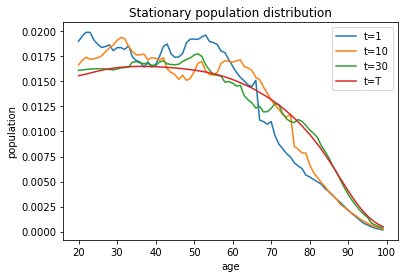

In [63]:
g_n_path, omega_path_new, imm_rate = get_dist_path(20, 80, 100)
t1 = omega_path_new[:,0]
t10 = omega_path_new[:,9]
t30 = omega_path_new[:,29]
t100 = omega_path_new[:,99]
age = np.arange(20, 100, 1)
plt.plot(age, t1, label = 't=1')
plt.plot(age, t10, label = 't=10')
plt.plot(age, t30, label = 't=30')
plt.plot(age, t100, label = 't=T')
plt.xlabel('age')
plt.ylabel('population')
plt.title('Stationary population distribution')
plt.legend()
plt.show()

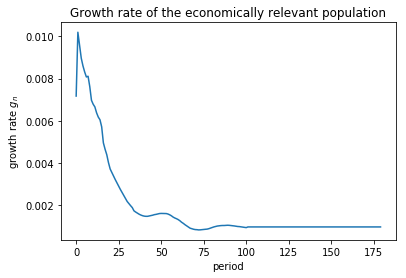

In [57]:
plt.plot(np.arange(180),g_n_path)
plt.xlabel('period')
plt.ylabel(r'growth rate $g_n$')
plt.title('Growth rate of the economically relevant population')
plt.show()